<a href="https://colab.research.google.com/github/Rjpiit/Image-processing-and-Audio-Reconstruction/blob/master/task2_image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests

url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSE61X3aJl68sQPFk0lfcjcgAEqifVzulmM0Q&s"
response = requests.get(url)

# Save the image
with open("image.jpg", "wb") as file:

    file.write(response.content)

print("Image downloaded successfully!")


Image downloaded successfully!


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [ ]:
img = torchvision.io.read_image("image.jpg")
print(img.shape)

torch.Size([3, 177, 284])


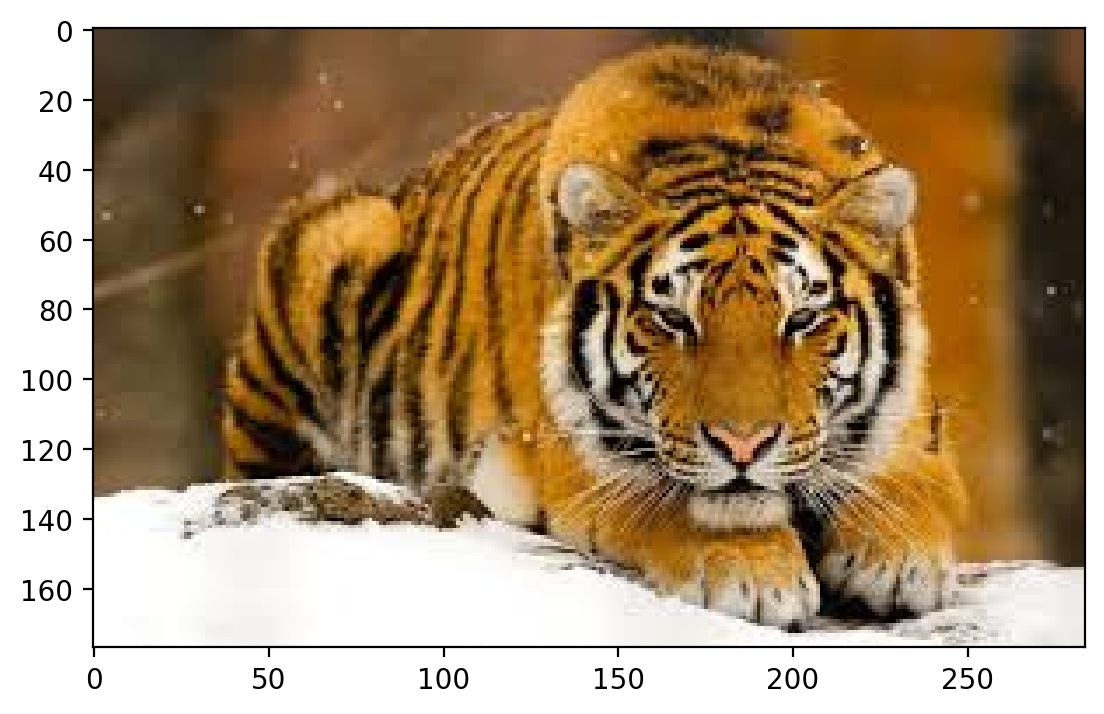

In [ ]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [ ]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [ ]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [ ]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.2941, 0.2902, 0.2902,  ..., 0.4196, 0.4275, 0.4314],
         [0.2941, 0.2902, 0.2902,  ..., 0.4196, 0.4275, 0.4314],
         [0.2941, 0.2902, 0.2902,  ..., 0.4196, 0.4275, 0.4314],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.9255, 0.9255, 0.9255],
         [1.0000, 1.0000, 1.0000,  ..., 0.9255, 0.9255, 0.9255],
         [1.0000, 1.0000, 1.0000,  ..., 0.9216, 0.9176, 0.9176]],

        [[0.2353, 0.2314, 0.2275,  ..., 0.2745, 0.2706, 0.2745],
         [0.2353, 0.2314, 0.2275,  ..., 0.2745, 0.2706, 0.2745],
         [0.2353, 0.2314, 0.2275,  ..., 0.2745, 0.2706, 0.2745],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.9216, 0.9216, 0.9216],
         [1.0000, 1.0000, 1.0000,  ..., 0.9216, 0.9216, 0.9216],
         [1.0000, 1.0000, 1.0000,  ..., 0.9176, 0.9137, 0.9137]],

        [[0.1608, 0.1569, 0.1647,  ..., 0.1686, 0.1686, 0.1725],
         [0.1608, 0.1569, 0.1647,  ..., 0.1686, 0.1686, 0.1725],
         [0.1608, 0.1569, 0.1647,  ..., 0.1686, 0.1686, 0.

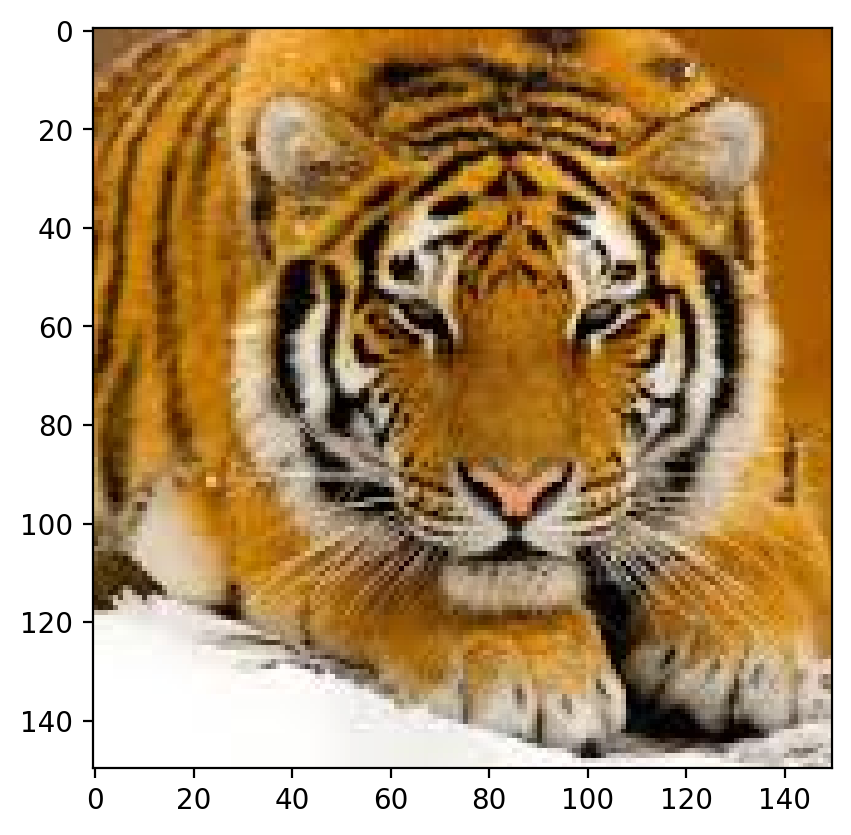

In [ ]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 25, 100, 150, 150)
crop.shape
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [ ]:
#plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())


In [ ]:
crop = crop.to(device)


In [ ]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [ ]:
img_X, img_Y = create_coordinate_map(crop)

img_X.shape, img_Y.shape

(torch.Size([22500, 2]), torch.Size([22500, 3]))

In [ ]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(img_X.cpu())

# Scale the X coordinates
img_X_scaled = scaler_X.transform(img_X.cpu())

# Move the scaled X coordinates to the GPU
img_X_scaled = torch.tensor(img_X_scaled).to(device)

# Set to dtype float32
img_X_scaled = img_X_scaled.float()

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


In [ ]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [ ]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [ ]:
train(net, 0.01, img_X_scaled, img_Y, 1000)

Epoch 0 loss: 0.368932
Epoch 100 loss: 0.054211
Epoch 200 loss: 0.053285
Epoch 300 loss: 0.053285
Epoch 400 loss: 0.053285
Epoch 500 loss: 0.053285
Epoch 600 loss: 0.053285
Epoch 700 loss: 0.053285
Epoch 800 loss: 0.053285
Epoch 900 loss: 0.053285


0.053285058587789536

In [ ]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

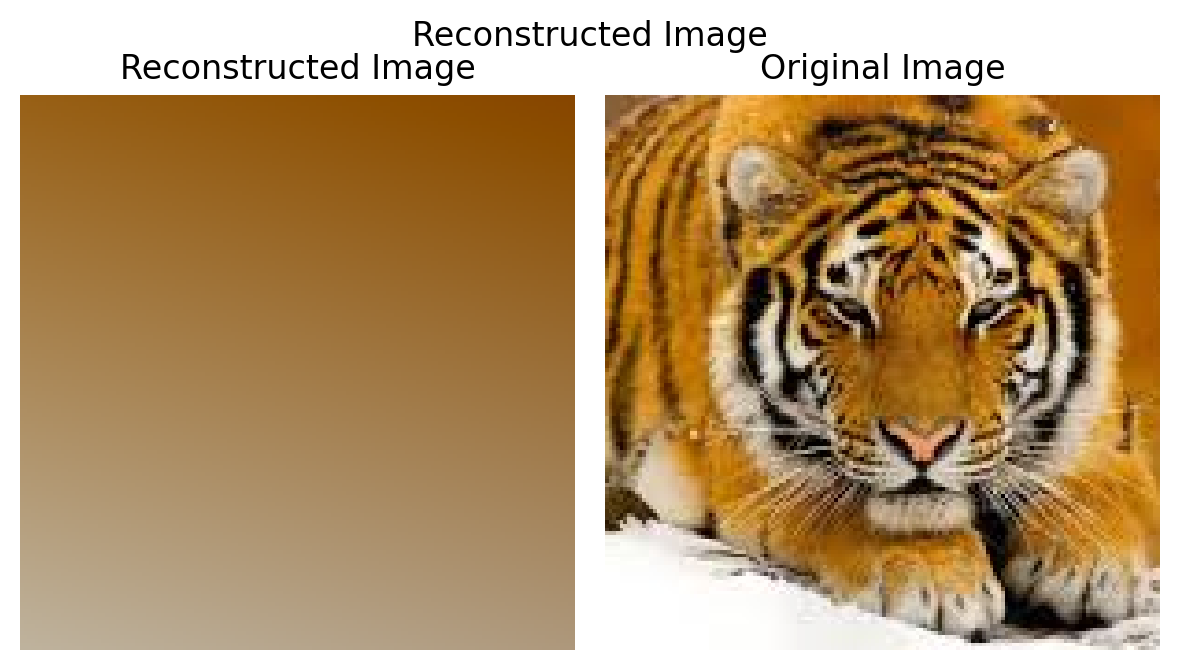

In [ ]:
plot_reconstructed_and_original_image(crop, net, img_X_scaled, title="Reconstructed Image")

In [ ]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

X_rff = create_rff_features(img_X_scaled, 15000, 0.008)
X_rff.shape

torch.Size([22500, 15000])

In [ ]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, img_Y, 2500)

Epoch 0 loss: 0.308120
Epoch 100 loss: 0.050836
Epoch 200 loss: 0.025046
Epoch 300 loss: 0.019179
Epoch 400 loss: 0.015499
Epoch 500 loss: 0.012823
Epoch 600 loss: 0.010796
Epoch 700 loss: 0.009219
Epoch 800 loss: 0.007967
Epoch 900 loss: 0.006955
Epoch 1000 loss: 0.006126
Epoch 1100 loss: 0.005439
Epoch 1200 loss: 0.004864
Epoch 1300 loss: 0.004378
Epoch 1400 loss: 0.003965
Epoch 1500 loss: 0.003612
Epoch 1600 loss: 0.003309
Epoch 1700 loss: 0.003047
Epoch 1800 loss: 0.002821
Epoch 1900 loss: 0.002624
Epoch 2000 loss: 0.002453
Epoch 2100 loss: 0.002305
Epoch 2200 loss: 0.002175
Epoch 2300 loss: 0.002062
Epoch 2400 loss: 0.001963


0.0018767137080430984

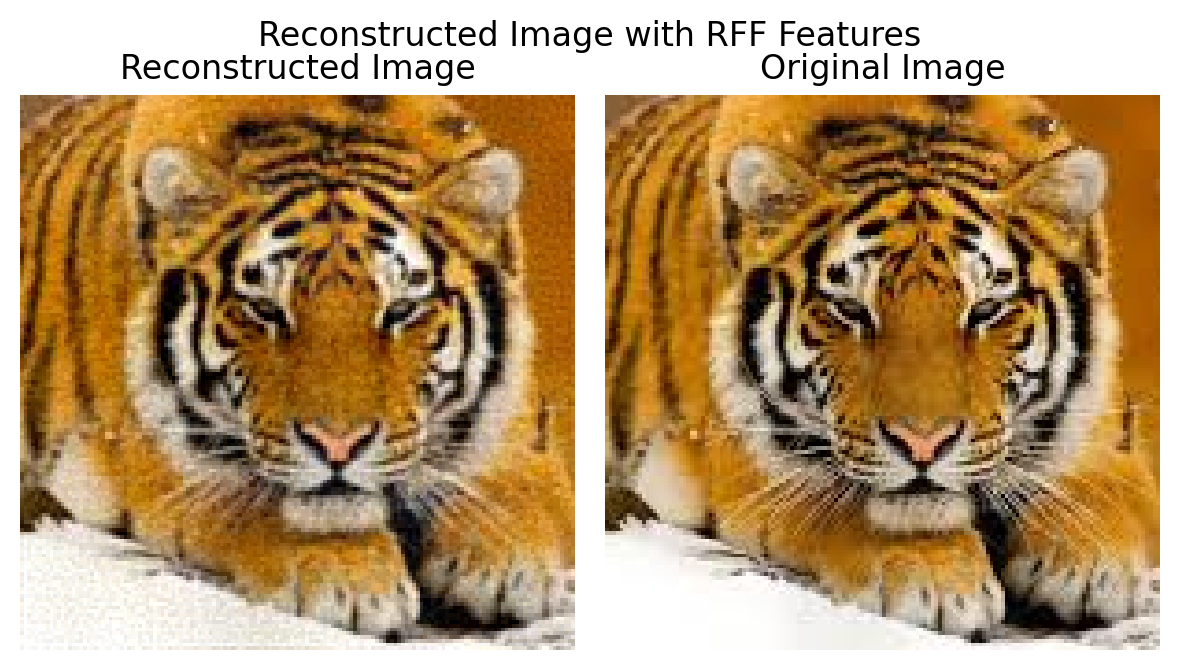

In [ ]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

In [ ]:
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr
def calculate_rmse(original, reconstructed):
    original = original.cpu().numpy().reshape(-1)
    reconstructed = reconstructed.cpu().numpy().reshape(-1)
    return np.sqrt(mean_squared_error(original, reconstructed))

def calculate_psnr(original, reconstructed):
    original = rearrange(original.cpu(), 'c h w -> h w c').numpy()
    reconstructed = reconstructed.cpu().numpy().reshape(original.shape)
    return psnr(original, reconstructed, data_range=original.max() - original.min())

In [ ]:
with torch.no_grad():
    reconstructed = net(X_rff).cpu()
rmse = calculate_rmse(img_Y, reconstructed)
psnr_value = calculate_psnr(crop, reconstructed)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr_value:.4f}")

Root Mean Squared Error (RMSE): 0.0433
Peak Signal-to-Noise Ratio (PSNR): 27.2679
